In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import scipy.stats as st

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [51]:
#data base path
database_path = "./Resources/hawaii.sqlite"

In [52]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

In [53]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [54]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station  = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

#Define start and end date of vacation
start_date = '2018-06-01'
end_date = '2018-06-15'

#convert string date to date format
start_dt = (dt.datetime.strptime(start_date,"%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date,"%Y-%m-%d")).date()

#calculate dates one year ago
startdate_oneyearprior = start_dt - dt.timedelta(days=365)
enddate_oneyearprior = end_dt - dt.timedelta(days=365)
temps=calc_temps(startdate_oneyearprior,enddate_oneyearprior)
tmin = temps[0][0]
tavg = round(temps[0][1],2)
tmax=temps[0][2]

#print temps
print(f"Minimum Temp:{tmin} | Average temp:{tavg} | Max Temp: {tmax}")

Minimum Temp:72.0 | Average temp:77.42 | Max Temp: 83.0


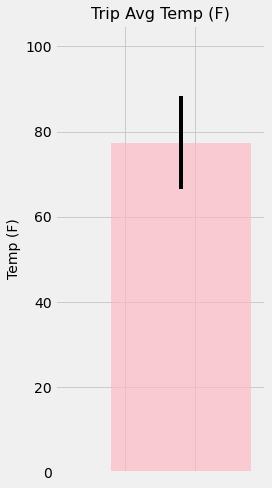

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror = tmax-tmin

#plot bar chart
plt.figure(figsize = (4,7))
plt.bar(1.5,height=tavg,yerr=yerror, width=2, color='lightpink',alpha=0.65,align="center")
xaxis_values = np.arange(-0.3,3.5,step=1)
plt.title("Trip Avg Temp (F)", fontsize = 16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0,105)
plt.xticks(xaxis_values,"")
plt.tight_layout()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [60]:
### Daily Rainfall Average

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# --- get all precipitation data from dataset for one year ago dates using SQLAlchemy and save in dataframe ---
prcp_station_df = pd.DataFrame(session.query(Measurement.date, Measurement.station, Measurement.prcp).\
                               filter((Measurement.date >= startdate_oneyearprior) & \
                               (Measurement.date <= enddate_oneyearprior)).all())
prcp_station_df

,0,1,2
0,2017-06-01,USC00519397,0.00
1,2017-06-02,USC00519397,0.00
2,2017-06-03,USC00519397,0.02
3,2017-06-04,USC00519397,0.00
4,2017-06-05,USC00519397,0.00
...,...,...,...
92,2017-06-11,USC00516128,0.70
93,2017-06-12,USC00516128,0.81
94,2017-06-13,USC00516128,0.65
95,2017-06-14,USC00516128,0.81


In [61]:
# --- check and drop null values from prcp_station_df---
print("Checking for null values...")
#print(f"There are {prcp_station_df['prcp'].isnull().sum()} null values in the precipitation data - dropping!")

prcp_station_df.dropna(axis=0, how="any", inplace=True)

# --- group by station and get total precipitation amount for each station ---
total_prcp = pd.DataFrame(prcp_station_df.groupby('station').sum())

Checking for null values...


KeyError: 'station'

In [62]:
# --- get station data from station table and save in dataframe ---
station_df = pd.DataFrame(session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
                                        Station.elevation).all())


# --- merge the two dataframes together, sort by total precipitation amount ---
rainfall_per_station_df = pd.merge(total_prcp, station_df, on="station").rename(columns={"prcp":"total precipitation (in)"})
rainfall_per_station_df.sort_values('total precipitation (in)', ascending=False, inplace=True)
rainfall_per_station_df.reset_index(inplace=True, drop=True)

# --- display the dataframe ---
rainfall_per_station_df

NameError: name 'total_prcp' is not defined

### Daily Temperature Normals

In [63]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [64]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

# Strip off the year and save a list of strings in the format %m-%d

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
# Use the start and end date to create a range of dates

# --- create an empty list to store range of dates ---
trip_dates = []

# --- new variable to act as start date (so that actual start date is unchanged) ---
current_date = start_date

# --- while loop to append dates to list in the format %m-%d ---
while current_date <= end_date:
    month = current_date.strftime('%m')
    day = current_date.strftime('%d')
    trip_dates.append(f"{month}-{day}")
    current_date += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date

# --- create an empty list to store normals ---
normals = []

# --- for loop to calculate normals for each date in trip_dates list ---
for i in range(len(trip_dates)):
    day_normal = daily_normals(trip_dates[i])
    normals.append(day_normal[0])
    



AttributeError: 'str' object has no attribute 'strftime'

In [65]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

dailynormals_df = pd.DataFrame(normals, columns =['T-Min (F)', 'T-Avg (F)', 'T-Max(F)']) 
dailynormals_df["Date"] = trip_dates
dailynormals_df.set_index("Date")

NameError: name 'normals' is not defined

In [66]:
# Plot the daily normals as an area plot with `stacked=False`

dailynormals_df.plot.area(figsize=(10,6), stacked=False, alpha = 0.2, rot=30, fontsize=12)

plt.xticks(np.arange(len(trip_dates)), labels=trip_dates)

plt.title(f"Daily Normals from {start_date} to {end_date}", fontsize=18)
plt.xlabel("Date (2018)", fontsize=16)
plt.ylabel("Temperature (F)", fontsize=16)

plt.tight_layout()
plt.savefig("Images/dailynormals.png")
plt.show()

NameError: name 'dailynormals_df' is not defined

## Close Session